In [1]:
! ls p8_ee_tt_ecm380/
! pip install pyhepmc
! pip install uproot

reco_p8_ee_tt_ecm380_10.root  sim_p8_ee_tt_ecm380_10.hepmc
reco_p8_ee_tt_ecm380_1.root   sim_p8_ee_tt_ecm380_1.hepmc
reco_p8_ee_tt_ecm380_2.root   sim_p8_ee_tt_ecm380_2.hepmc
reco_p8_ee_tt_ecm380_3.root   sim_p8_ee_tt_ecm380_3.hepmc
reco_p8_ee_tt_ecm380_4.root   sim_p8_ee_tt_ecm380_4.hepmc
reco_p8_ee_tt_ecm380_5.root   sim_p8_ee_tt_ecm380_5.hepmc
reco_p8_ee_tt_ecm380_6.root   sim_p8_ee_tt_ecm380_6.hepmc
reco_p8_ee_tt_ecm380_7.root   sim_p8_ee_tt_ecm380_7.hepmc
reco_p8_ee_tt_ecm380_8.root   sim_p8_ee_tt_ecm380_8.hepmc
reco_p8_ee_tt_ecm380_9.root   sim_p8_ee_tt_ecm380_9.hepmc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.8 MB/s eta 0:00:00a 0:00:01


In [3]:
import pyhepmc
import uproot
import awkward as ak

# From root -> parquet, adding bquark p4 as additional info

In [4]:
import numpy as np
import awkward
import uproot
import vector
import glob
import os
import sys
import multiprocessing
import tqdm
from scipy.sparse import coo_matrix

track_coll = "SiTracks_Refitted"
mc_coll = "MCParticles"

# the feature matrices will be saved in this order
particle_feature_order = ["PDG", "charge", "pt", "eta", "sin_phi", "cos_phi", "energy"]
bquark_feature_order = ["energy", "pt", "eta", "phi"]

# arrange track and cluster features such that pt (et), eta, phi, p (energy) are in the same spot
# so we can easily use them in skip connections
track_feature_order = [
    "elemtype",
    "pt",
    "eta",
    "sin_phi",
    "cos_phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]
cluster_feature_order = [
    "elemtype",
    "et",
    "eta",
    "sin_phi",
    "cos_phi",
    "energy",
    "position.x",
    "position.y",
    "position.z",
    "iTheta",
    "energy_ecal",
    "energy_hcal",
    "energy_other",
    "num_hits",
    "sigma_x",
    "sigma_y",
    "sigma_z",
]
hit_feature_order = [
    "elemtype",
    "et",
    "eta",
    "sin_phi",
    "cos_phi",
    "energy",
    "position.x",
    "position.y",
    "position.z",
    "time",
    "subdetector",
    "type",
]


def track_pt(omega):
    a = 3 * 10**-4
    b = 4  # B-field in tesla, from clicRec_e4h_input

    return a * np.abs(b / omega)


def map_pdgid_to_candid(pdgid, charge):
    if pdgid == 0:
        return 0

    # photon, electron, muon
    if pdgid in [22, 11, 13]:
        return pdgid

    # charged hadron
    if abs(charge) > 0:
        return 211

    # neutral hadron
    return 130


def map_charged_to_neutral(pdg):
    if pdg == 0:
        return 0
    if pdg == 11 or pdg == 22:
        return 22
    return 130


def map_neutral_to_charged(pdg):
    if pdg == 130 or pdg == 22:
        return 211
    return pdg


def sanitize(arr):
    arr[np.isnan(arr)] = 0.0
    arr[np.isinf(arr)] = 0.0


class EventData:
    def __init__(
        self,
        gen_features,
        hit_features,
        cluster_features,
        track_features,
        genparticle_to_hit,
        genparticle_to_track,
        hit_to_cluster,
        gp_merges,
    ):
        self.gen_features = gen_features  # feature matrix of the genparticles
        self.hit_features = hit_features  # feature matrix of the calo hits
        self.cluster_features = cluster_features  # feature matrix of the calo clusters
        self.track_features = track_features  # feature matrix of the tracks
        self.genparticle_to_hit = genparticle_to_hit  # sparse COO matrix of genparticles to hits (idx_gp, idx_hit, weight)
        self.genparticle_to_track = (
            genparticle_to_track  # sparse COO matrix of genparticles to tracks (idx_gp, idx_track, weight)
        )
        self.hit_to_cluster = hit_to_cluster  # sparse COO matrix of hits to clusters (idx_hit, idx_cluster, weight)
        self.gp_merges = gp_merges  # sparse COO matrix of any merged genparticles

        self.genparticle_to_hit = (
            np.array(self.genparticle_to_hit[0]),
            np.array(self.genparticle_to_hit[1]),
            np.array(self.genparticle_to_hit[2]),
        )
        self.genparticle_to_track = (
            np.array(self.genparticle_to_track[0]),
            np.array(self.genparticle_to_track[1]),
            np.array(self.genparticle_to_track[2]),
        )
        self.hit_to_cluster = (
            np.array(self.hit_to_cluster[0]),
            np.array(self.hit_to_cluster[1]),
            np.array(self.hit_to_cluster[2]),
        )
        self.gp_merges = np.array(self.gp_merges[0]), np.array(self.gp_merges[1])


def hits_to_features(hit_data, iev, coll, feats):
    feat_arr = {f: hit_data[coll + "." + f][iev] for f in feats}

    # set the subdetector type
    sdcoll = "subdetector"
    feat_arr[sdcoll] = np.zeros(len(feat_arr["type"]), dtype=np.int32)
    if coll.startswith("ECAL"):
        feat_arr[sdcoll][:] = 0
    elif coll.startswith("HCAL"):
        feat_arr[sdcoll][:] = 1
    else:
        feat_arr[sdcoll][:] = 2

    # hit elemtype is always 2
    feat_arr["elemtype"] = 2 * np.ones(len(feat_arr["type"]), dtype=np.int32)

    # precompute some approximate et, eta, phi
    pos_mag = np.sqrt(feat_arr["position.x"] ** 2 + feat_arr["position.y"] ** 2 + feat_arr["position.z"] ** 2)
    px = (feat_arr["position.x"] / pos_mag) * feat_arr["energy"]
    py = (feat_arr["position.y"] / pos_mag) * feat_arr["energy"]
    pz = (feat_arr["position.z"] / pos_mag) * feat_arr["energy"]
    feat_arr["et"] = np.sqrt(px**2 + py**2)
    feat_arr["eta"] = 0.5 * np.log((feat_arr["energy"] + pz) / (feat_arr["energy"] - pz))
    feat_arr["sin_phi"] = py / feat_arr["energy"]
    feat_arr["cos_phi"] = px / feat_arr["energy"]

    return awkward.Record(feat_arr)


def get_calohit_matrix_and_genadj(hit_data, calohit_links, iev, collectionIDs):
    feats = ["type", "cellID", "energy", "energyError", "time", "position.x", "position.y", "position.z"]

    hit_idx_global = 0
    hit_idx_global_to_local = {}
    hit_feature_matrix = []
    for col in sorted(hit_data.keys()):
        icol = collectionIDs[col]
        hit_features = hits_to_features(hit_data[col], iev, col, feats)
        hit_feature_matrix.append(hit_features)
        for ihit in range(len(hit_data[col][col + ".energy"][iev])):
            hit_idx_global_to_local[hit_idx_global] = (icol, ihit)
            hit_idx_global += 1
    hit_idx_local_to_global = {v: k for k, v in hit_idx_global_to_local.items()}
    hit_feature_matrix = awkward.Record(
        {
            k: awkward.concatenate([hit_feature_matrix[i][k] for i in range(len(hit_feature_matrix))])
            for k in hit_feature_matrix[0].fields
        }
    )

    # add all edges from genparticle to calohit
    calohit_to_gen_weight = calohit_links["CalohitMCTruthLink.weight"][iev]
    calohit_to_gen_calo_colid = calohit_links["CalohitMCTruthLink#0.collectionID"][iev]
    calohit_to_gen_gen_colid = calohit_links["CalohitMCTruthLink#1.collectionID"][iev]
    calohit_to_gen_calo_idx = calohit_links["CalohitMCTruthLink#0.index"][iev]
    calohit_to_gen_gen_idx = calohit_links["CalohitMCTruthLink#1.index"][iev]
    genparticle_to_hit_matrix_coo0 = []
    genparticle_to_hit_matrix_coo1 = []
    genparticle_to_hit_matrix_w = []
    for calo_colid, calo_idx, gen_colid, gen_idx, w in zip(
        calohit_to_gen_calo_colid,
        calohit_to_gen_calo_idx,
        calohit_to_gen_gen_colid,
        calohit_to_gen_gen_idx,
        calohit_to_gen_weight,
    ):
        genparticle_to_hit_matrix_coo0.append(gen_idx)
        genparticle_to_hit_matrix_coo1.append(hit_idx_local_to_global[(calo_colid, calo_idx)])
        genparticle_to_hit_matrix_w.append(w)

    return (
        hit_feature_matrix,
        (genparticle_to_hit_matrix_coo0, genparticle_to_hit_matrix_coo1, genparticle_to_hit_matrix_w),
        hit_idx_local_to_global,
    )


def hit_cluster_adj(prop_data, hit_idx_local_to_global, iev):
    coll_arr = prop_data["PandoraClusters#1"]["PandoraClusters#1.collectionID"][iev]
    idx_arr = prop_data["PandoraClusters#1"]["PandoraClusters#1.index"][iev]
    hits_begin = prop_data["PandoraClusters"]["PandoraClusters.hits_begin"][iev]
    hits_end = prop_data["PandoraClusters"]["PandoraClusters.hits_end"][iev]

    # index in the array of all hits
    hit_to_cluster_matrix_coo0 = []
    # index in the cluster array
    hit_to_cluster_matrix_coo1 = []

    # weight
    hit_to_cluster_matrix_w = []

    # loop over all clusters
    for icluster in range(len(hits_begin)):

        # get the slice in the hit array corresponding to this cluster
        hbeg = hits_begin[icluster]
        hend = hits_end[icluster]
        idx_range = idx_arr[hbeg:hend]
        coll_range = coll_arr[hbeg:hend]

        # add edges from hit to cluster
        for icol, idx in zip(coll_range, idx_range):
            hit_to_cluster_matrix_coo0.append(hit_idx_local_to_global[(icol, idx)])
            hit_to_cluster_matrix_coo1.append(icluster)
            hit_to_cluster_matrix_w.append(1.0)
    return hit_to_cluster_matrix_coo0, hit_to_cluster_matrix_coo1, hit_to_cluster_matrix_w


def gen_to_features(prop_data, iev):
    gen_arr = prop_data[mc_coll][iev]
    gen_arr = {k.replace(mc_coll + ".", ""): gen_arr[k] for k in gen_arr.fields}

    MCParticles_p4 = vector.awk(
        awkward.zip(
            {"mass": gen_arr["mass"], "x": gen_arr["momentum.x"], "y": gen_arr["momentum.y"], "z": gen_arr["momentum.z"]}
        )
    )
    gen_arr["pt"] = MCParticles_p4.pt
    gen_arr["eta"] = MCParticles_p4.eta
    gen_arr["phi"] = MCParticles_p4.phi
    gen_arr["energy"] = MCParticles_p4.energy
    gen_arr["sin_phi"] = np.sin(gen_arr["phi"])
    gen_arr["cos_phi"] = np.cos(gen_arr["phi"])

    return awkward.Record(
        {
            "PDG": gen_arr["PDG"],
            "generatorStatus": gen_arr["generatorStatus"],
            "charge": gen_arr["charge"],
            "pt": gen_arr["pt"],
            "eta": gen_arr["eta"],
            "phi": gen_arr["phi"],
            "sin_phi": gen_arr["sin_phi"],
            "cos_phi": gen_arr["cos_phi"],
            "energy": gen_arr["energy"],
        }
    )


def genparticle_track_adj(sitrack_links, iev):
    trk_to_gen_trkidx = sitrack_links["SiTracksMCTruthLink#0.index"][iev]
    trk_to_gen_genidx = sitrack_links["SiTracksMCTruthLink#1.index"][iev]
    trk_to_gen_w = sitrack_links["SiTracksMCTruthLink.weight"][iev]

    genparticle_to_track_matrix_coo0 = awkward.to_numpy(trk_to_gen_genidx)
    genparticle_to_track_matrix_coo1 = awkward.to_numpy(trk_to_gen_trkidx)
    genparticle_to_track_matrix_w = awkward.to_numpy(trk_to_gen_w)

    return genparticle_to_track_matrix_coo0, genparticle_to_track_matrix_coo1, genparticle_to_track_matrix_w


def cluster_to_features(prop_data, hit_features, hit_to_cluster, iev):
    cluster_arr = prop_data["PandoraClusters"][iev]
    feats = ["type", "position.x", "position.y", "position.z", "iTheta", "phi", "energy"]
    ret = {feat: cluster_arr["PandoraClusters." + feat] for feat in feats}

    hit_idx = np.array(hit_to_cluster[0])
    cluster_idx = np.array(hit_to_cluster[1])
    cl_energy_ecal = []
    cl_energy_hcal = []
    cl_energy_other = []
    num_hits = []
    cl_sigma_x = []
    cl_sigma_y = []
    cl_sigma_z = []

    n_cl = len(ret["energy"])
    for cl in range(n_cl):
        msk_cl = cluster_idx == cl
        hits = hit_idx[msk_cl]

        num_hits.append(len(hits))

        subdets = hit_features["subdetector"][hits]

        hits_energy = hit_features["energy"][hits]

        hits_posx = hit_features["position.x"][hits]
        hits_posy = hit_features["position.y"][hits]
        hits_posz = hit_features["position.z"][hits]

        energy_ecal = np.sum(hits_energy[subdets == 0])
        energy_hcal = np.sum(hits_energy[subdets == 1])
        energy_other = np.sum(hits_energy[subdets == 2])

        cl_energy_ecal.append(energy_ecal)
        cl_energy_hcal.append(energy_hcal)
        cl_energy_other.append(energy_other)

        cl_sigma_x.append(np.std(hits_posx))
        cl_sigma_y.append(np.std(hits_posy))
        cl_sigma_z.append(np.std(hits_posz))

    ret["energy_ecal"] = np.array(cl_energy_ecal)
    ret["energy_hcal"] = np.array(cl_energy_hcal)
    ret["energy_other"] = np.array(cl_energy_other)
    ret["num_hits"] = np.array(num_hits)
    ret["sigma_x"] = np.array(cl_sigma_x)
    ret["sigma_y"] = np.array(cl_sigma_y)
    ret["sigma_z"] = np.array(cl_sigma_z)

    tt = awkward.to_numpy(np.tan(ret["iTheta"] / 2.0))
    eta = awkward.to_numpy(-np.log(tt, where=tt > 0))
    eta[tt <= 0] = 0.0
    ret["eta"] = eta

    costheta = np.cos(ret["iTheta"])
    ez = ret["energy"] * costheta
    ret["et"] = np.sqrt(ret["energy"] ** 2 - ez**2)

    # cluster is always type 2
    ret["elemtype"] = 2 * np.ones(n_cl, dtype=np.float32)

    ret["sin_phi"] = np.sin(ret["phi"])
    ret["cos_phi"] = np.cos(ret["phi"])

    return awkward.Record(ret)


def track_to_features(prop_data, iev):
    track_arr = prop_data[track_coll][iev]
    feats_from_track = ["type", "chi2", "ndf", "dEdx", "dEdxError", "radiusOfInnermostHit"]
    ret = {feat: track_arr[track_coll + "." + feat] for feat in feats_from_track}
    n_tr = len(ret["type"])

    # get the index of the first track state
    trackstate_idx = prop_data[track_coll][track_coll + ".trackStates_begin"][iev]
    # get the properties of the track at the first track state (at the origin)
    for k in ["tanLambda", "D0", "phi", "omega", "Z0", "time"]:
        ret[k] = awkward.to_numpy(prop_data["SiTracks_1"]["SiTracks_1." + k][iev][trackstate_idx])

    ret["pt"] = awkward.to_numpy(track_pt(ret["omega"]))
    ret["px"] = awkward.to_numpy(np.cos(ret["phi"])) * ret["pt"]
    ret["py"] = awkward.to_numpy(np.sin(ret["phi"])) * ret["pt"]
    ret["pz"] = awkward.to_numpy(ret["tanLambda"]) * ret["pt"]
    ret["p"] = np.sqrt(ret["px"] ** 2 + ret["py"] ** 2 + ret["pz"] ** 2)
    cos_theta = np.divide(ret["pz"], ret["p"], where=ret["p"] > 0)
    theta = np.arccos(cos_theta)
    tt = np.tan(theta / 2.0)
    eta = awkward.to_numpy(-np.log(tt, where=tt > 0))
    eta[tt <= 0] = 0.0
    ret["eta"] = eta

    ret["sin_phi"] = np.sin(ret["phi"])
    ret["cos_phi"] = np.cos(ret["phi"])

    # track is always type 1
    ret["elemtype"] = 1 * np.ones(n_tr, dtype=np.float32)

    return awkward.Record(ret)


def filter_adj(adj, all_to_filtered):
    i0s_new = []
    i1s_new = []
    ws_new = []
    for i0, i1, w in zip(*adj):
        if i0 in all_to_filtered:
            i0_new = all_to_filtered[i0]
            i0s_new.append(i0_new)
            i1s_new.append(i1)
            ws_new.append(w)
    return np.array(i0s_new), np.array(i1s_new), np.array(ws_new)


def get_genparticles_and_adjacencies(prop_data, hit_data, calohit_links, sitrack_links, iev, collectionIDs):
    gen_features = gen_to_features(prop_data, iev)

    hit_features, genparticle_to_hit, hit_idx_local_to_global = get_calohit_matrix_and_genadj(
        hit_data, calohit_links, iev, collectionIDs
    )
    hit_to_cluster = hit_cluster_adj(prop_data, hit_idx_local_to_global, iev)
    cluster_features = cluster_to_features(prop_data, hit_features, hit_to_cluster, iev)
    track_features = track_to_features(prop_data, iev)
    genparticle_to_track = genparticle_track_adj(sitrack_links, iev)

    n_gp = awkward.count(gen_features["PDG"])
    n_track = awkward.count(track_features["type"])
    n_hit = awkward.count(hit_features["type"])
    n_cluster = awkward.count(cluster_features["type"])

    if len(genparticle_to_track[0]) > 0:
        gp_to_track = (
            coo_matrix((genparticle_to_track[2], (genparticle_to_track[0], genparticle_to_track[1])), shape=(n_gp, n_track))
            .max(axis=1)
            .todense()
        )
    else:
        gp_to_track = np.zeros((n_gp, 1))

    gp_to_calohit = coo_matrix((genparticle_to_hit[2], (genparticle_to_hit[0], genparticle_to_hit[1])), shape=(n_gp, n_hit))
    calohit_to_cluster = coo_matrix((hit_to_cluster[2], (hit_to_cluster[0], hit_to_cluster[1])), shape=(n_hit, n_cluster))
    gp_to_cluster = (gp_to_calohit * calohit_to_cluster).sum(axis=1)

    # 60% of the hits of a track must come from the genparticle
    gp_in_tracker = np.array(gp_to_track >= 0.6)[:, 0]

    # at least 10% of the energy of the genparticle should be matched to a calorimeter cluster
    gp_in_calo = (np.array(gp_to_cluster)[:, 0] / gen_features["energy"]) > 0.1

    gp_interacted_with_detector = gp_in_tracker | gp_in_calo
    
    # select and store bquark, should have 2 per jet
    b_PDGID = 5
    hard_status_code = 23
    is_bquark = np.absolute(gen_features["PDG"])==b_PDGID
    is_status23 = np.absolute(gen_features["generatorStatus"])==hard_status_code
    
    bquark_features = awkward.Record({
        "energy":gen_features["energy"][is_bquark & is_status23],
        "pt":gen_features["pt"][is_bquark & is_status23],
        "eta":gen_features["eta"][is_bquark & is_status23],
        "phi":gen_features["phi"][is_bquark & is_status23],
    })
        
    mask_visible = (gen_features["energy"] > 0.01) & gp_interacted_with_detector
    # print("gps total={} visible={}".format(n_gp, np.sum(mask_visible)))
    idx_all_masked = np.where(mask_visible)[0]
    genpart_idx_all_to_filtered = {idx_all: idx_filtered for idx_filtered, idx_all in enumerate(idx_all_masked)}

    gen_features = awkward.Record({feat: gen_features[feat][mask_visible] for feat in gen_features.fields})

    genparticle_to_hit = filter_adj(genparticle_to_hit, genpart_idx_all_to_filtered)
    genparticle_to_track = filter_adj(genparticle_to_track, genpart_idx_all_to_filtered)

    return (EventData(
        gen_features,
        hit_features,
        cluster_features,
        track_features,
        genparticle_to_hit,
        genparticle_to_track,
        hit_to_cluster,
        ([], []),
    ), bquark_features)

def assign_genparticles_to_obj_and_merge(gpdata):

    n_gp = awkward.count(gpdata.gen_features["PDG"])
    n_track = awkward.count(gpdata.track_features["type"])
    n_hit = awkward.count(gpdata.hit_features["type"])
    n_cluster = awkward.count(gpdata.cluster_features["type"])
    
    gp_to_track = np.array(
        coo_matrix(
            (gpdata.genparticle_to_track[2], (gpdata.genparticle_to_track[0], gpdata.genparticle_to_track[1])),
            shape=(n_gp, n_track),
        ).todense()
    )

    gp_to_calohit = coo_matrix(
        (gpdata.genparticle_to_hit[2], (gpdata.genparticle_to_hit[0], gpdata.genparticle_to_hit[1])), shape=(n_gp, n_hit)
    )
    calohit_to_cluster = coo_matrix(
        (gpdata.hit_to_cluster[2], (gpdata.hit_to_cluster[0], gpdata.hit_to_cluster[1])), shape=(n_hit, n_cluster)
    )

    gp_to_cluster = np.array((gp_to_calohit * calohit_to_cluster).todense())

    # map each genparticle to a track or a cluster
    gp_to_obj = -1 * np.ones((n_gp, 2), dtype=np.int32)
    set_used_tracks = set([])
    set_used_clusters = set([])
    gps_sorted_energy = sorted(range(n_gp), key=lambda x: gpdata.gen_features["energy"][x], reverse=True)

    for igp in gps_sorted_energy:

        # first check if we can match the genparticle to a track
        matched_tracks = gp_to_track[igp]
        trks = np.where(matched_tracks)[0]
        trks = sorted(trks, key=lambda x: matched_tracks[x], reverse=True)
        for trk in trks:
            # if the track was not already used for something else
            if trk not in set_used_tracks:
                gp_to_obj[igp, 0] = trk
                set_used_tracks.add(trk)
                break

        # if there was no matched track, try a cluster
        if gp_to_obj[igp, 0] == -1:
            matched_clusters = gp_to_cluster[igp]
            clusters = np.where(matched_clusters)[0]
            clusters = sorted(clusters, key=lambda x: matched_clusters[x], reverse=True)
            for cl in clusters:
                if cl not in set_used_clusters:
                    gp_to_obj[igp, 1] = cl
                    set_used_clusters.add(cl)
                    break

    # the genparticles that could not be matched to a track or cluster are merged to the closest genparticle
    unmatched = np.where((gp_to_obj[:, 0] == -1) & (gp_to_obj[:, 1] == -1))[0]
    mask_gp_unmatched = np.ones(n_gp, dtype=bool)

    pt_arr = np.array(awkward.to_numpy(gpdata.gen_features["pt"]))
    eta_arr = np.array(awkward.to_numpy(gpdata.gen_features["eta"]))
    phi_arr = np.array(awkward.to_numpy(gpdata.gen_features["phi"]))
    energy_arr = np.array(awkward.to_numpy(gpdata.gen_features["energy"]))

    # now merge unmatched genparticles to their closest genparticle
    gp_merges_gp0 = []
    gp_merges_gp1 = []
    for igp_unmatched in unmatched:
        mask_gp_unmatched[igp_unmatched] = False
        idx_best_cluster = np.argmax(gp_to_cluster[igp_unmatched])
        idx_gp_bestcluster = np.where(gp_to_obj[:, 1] == idx_best_cluster)[0]

        # if the genparticle is not matched to any cluster, then it left a few hits to some other track
        # this is rare, happens only for low-pT particles and we don't want to try to reconstruct it
        if len(idx_gp_bestcluster) != 1:
            print("unmatched pt=", pt_arr[igp_unmatched])
            continue

        idx_gp_bestcluster = idx_gp_bestcluster[0]

        gp_merges_gp0.append(idx_gp_bestcluster)
        gp_merges_gp1.append(igp_unmatched)

        vec0 = vector.obj(
            pt=gpdata.gen_features["pt"][igp_unmatched],
            eta=gpdata.gen_features["eta"][igp_unmatched],
            phi=gpdata.gen_features["phi"][igp_unmatched],
            e=gpdata.gen_features["energy"][igp_unmatched],
        )
        vec1 = vector.obj(
            pt=gpdata.gen_features["pt"][idx_gp_bestcluster],
            eta=gpdata.gen_features["eta"][idx_gp_bestcluster],
            phi=gpdata.gen_features["phi"][idx_gp_bestcluster],
            e=gpdata.gen_features["energy"][idx_gp_bestcluster],
        )
        vec = vec0 + vec1
        pt_arr[idx_gp_bestcluster] = vec.pt
        eta_arr[idx_gp_bestcluster] = vec.eta
        phi_arr[idx_gp_bestcluster] = vec.phi
        energy_arr[idx_gp_bestcluster] = vec.energy

    gen_features_new = {
        "PDG": np.abs(gpdata.gen_features["PDG"][mask_gp_unmatched]),
        "charge": gpdata.gen_features["charge"][mask_gp_unmatched],
        "pt": pt_arr[mask_gp_unmatched],
        "eta": eta_arr[mask_gp_unmatched],
        "sin_phi": np.sin(phi_arr[mask_gp_unmatched]),
        "cos_phi": np.cos(phi_arr[mask_gp_unmatched]),
        "energy": energy_arr[mask_gp_unmatched],
    }
    assert (np.sum(gen_features_new["energy"]) - np.sum(gpdata.gen_features["energy"])) < 1e-2
    
    idx_all_masked = np.where(mask_gp_unmatched)[0]
    genpart_idx_all_to_filtered = {idx_all: idx_filtered for idx_filtered, idx_all in enumerate(idx_all_masked)}
    genparticle_to_hit = filter_adj(gpdata.genparticle_to_hit, genpart_idx_all_to_filtered)
    genparticle_to_track = filter_adj(gpdata.genparticle_to_track, genpart_idx_all_to_filtered)
    gp_to_obj = gp_to_obj[mask_gp_unmatched]

    return (
        EventData(
            gen_features_new,
            gpdata.hit_features,
            gpdata.cluster_features,
            gpdata.track_features,
            genparticle_to_hit,
            genparticle_to_track,
            gpdata.hit_to_cluster,
            (gp_merges_gp0, gp_merges_gp1),
        ),
        gp_to_obj, 
    )


# for each PF element (track, cluster), get the index of the best-matched particle (gen or reco)
# if the PF element has no best-matched particle, returns -1
def assign_to_recoobj(n_obj, obj_to_ptcl, used_particles):
    obj_to_ptcl_all = -1 * np.ones(n_obj, dtype=np.int64)
    for iobj in range(n_obj):
        if iobj in obj_to_ptcl:
            iptcl = obj_to_ptcl[iobj]
            obj_to_ptcl_all[iobj] = iptcl
            assert used_particles[iptcl] == 0
            used_particles[iptcl] = 1
    return obj_to_ptcl_all


def get_recoptcl_to_obj(n_rps, reco_arr, idx_rp_to_track, idx_rp_to_cluster):
    track_to_rp = {}
    cluster_to_rp = {}

    # loop over the reco particles
    for irp in range(n_rps):
        assigned = False

        # find and loop over tracks associated to the reco particle
        trks_begin = reco_arr["tracks_begin"][irp]
        trks_end = reco_arr["tracks_end"][irp]
        for itrk in range(trks_begin, trks_end):

            # get the index of the track in the track collection
            itrk_real = idx_rp_to_track[itrk]
            assert itrk_real not in track_to_rp
            track_to_rp[itrk_real] = irp
            assigned = True

        # only look for clusters if tracks were not found
        if not assigned:

            # find and loop over clusters associated to the reco particle
            cls_begin = reco_arr["clusters_begin"][irp]
            cls_end = reco_arr["clusters_end"][irp]
            for icls in range(cls_begin, cls_end):

                # get the index of the cluster in the cluster collection
                icls_real = idx_rp_to_cluster[icls]
                assert icls_real not in cluster_to_rp
                cluster_to_rp[icls_real] = irp
    return track_to_rp, cluster_to_rp


def get_reco_properties(prop_data, iev):
    reco_arr = prop_data["MergedRecoParticles"][iev]
    reco_arr = {k.replace("MergedRecoParticles.", ""): reco_arr[k] for k in reco_arr.fields}

    reco_p4 = vector.awk(
        awkward.zip(
            {"mass": reco_arr["mass"], "x": reco_arr["momentum.x"], "y": reco_arr["momentum.y"], "z": reco_arr["momentum.z"]}
        )
    )
    reco_arr["pt"] = reco_p4.pt
    reco_arr["eta"] = reco_p4.eta
    reco_arr["phi"] = reco_p4.phi
    reco_arr["energy"] = reco_p4.energy

    msk = reco_arr["type"] != 0
    reco_arr = awkward.Record({k: reco_arr[k][msk] for k in reco_arr.keys()})
    return reco_arr


def get_particle_feature_matrix(pfelem_to_particle, feature_dict, features):
    feats = []
    for feat in features:
        feat_arr = feature_dict[feat]
        if len(feat_arr) == 0:
            feat_arr_reordered = feat_arr
        else:
            feat_arr_reordered = awkward.to_numpy(feat_arr[pfelem_to_particle])
            feat_arr_reordered[pfelem_to_particle == -1] = 0.0
        feats.append(feat_arr_reordered)
    feats = np.array(feats)
    return feats.T


def get_feature_matrix(feature_dict, features):
    feats = []
    for feat in features:
        feat_arr = awkward.to_numpy(feature_dict[feat])
        feats.append(feat_arr)
    feats = np.array(feats)
    return feats.T

def process_one_file(fn, ofn):

    # output exists, do not recreate
    # if os.path.isfile(ofn):
        # print("{} exists".format(ofn))
        # return

    print("loading {}".format(fn))
    fi = uproot.open(fn)

    arrs = fi["events"]

    collectionIDs = {
        k: v
        for k, v in zip(
            fi.get("metadata").arrays("CollectionIDs")["CollectionIDs"]["m_names"][0],
            fi.get("metadata").arrays("CollectionIDs")["CollectionIDs"]["m_collectionIDs"][0],
        )
    }

    prop_data = arrs.arrays(
        [
            mc_coll,
            track_coll,
            "SiTracks_1",
            "PandoraClusters",
            "PandoraClusters#1",
            "PandoraClusters#0",
            "MergedRecoParticles",
        ]
    )
    calohit_links = arrs.arrays(
        [
            "CalohitMCTruthLink.weight",
            "CalohitMCTruthLink#0.index",
            "CalohitMCTruthLink#0.collectionID",
            "CalohitMCTruthLink#1.index",
            "CalohitMCTruthLink#1.collectionID",
        ]
    )
    sitrack_links = arrs.arrays(
        [
            "SiTracksMCTruthLink.weight",
            "SiTracksMCTruthLink#0.index",
            "SiTracksMCTruthLink#0.collectionID",
            "SiTracksMCTruthLink#1.index",
            "SiTracksMCTruthLink#1.collectionID",
        ]
    )

    # maps the recoparticle track/cluster index (in tracks_begin,end and clusters_begin,end)
    # to the index in the track/cluster collection
    idx_rp_to_cluster = arrs["MergedRecoParticles#0/MergedRecoParticles#0.index"].array()
    idx_rp_to_track = arrs["MergedRecoParticles#1/MergedRecoParticles#1.index"].array()

    hit_data = {
        "ECALBarrel": arrs["ECALBarrel"].array(),
        "ECALEndcap": arrs["ECALEndcap"].array(),
        "ECALOther": arrs["ECALOther"].array(),
        "HCALBarrel": arrs["HCALBarrel"].array(),
        "HCALEndcap": arrs["HCALEndcap"].array(),
        "HCALOther": arrs["HCALOther"].array(),
        "MUON": arrs["MUON"].array(),
    }

    ret = []
    for iev in tqdm.tqdm(range(arrs.num_entries), total=arrs.num_entries):

        # get the reco particles
        reco_arr = get_reco_properties(prop_data, iev)
        reco_type = np.abs(reco_arr["type"])
        n_rps = len(reco_type)
        reco_features = awkward.Record(
            {
                "PDG": np.abs(reco_type),
                "charge": reco_arr["charge"],
                "pt": reco_arr["pt"],
                "eta": reco_arr["eta"],
                "sin_phi": np.sin(reco_arr["phi"]),
                "cos_phi": np.cos(reco_arr["phi"]),
                "energy": reco_arr["energy"],
            }
        )

        # get the genparticles and the links between genparticles and tracks/clusters
        gpdata, bquark_features = get_genparticles_and_adjacencies(prop_data, hit_data, calohit_links, sitrack_links, iev, collectionIDs)

        # find the reconstructable genparticles and associate them to the best track/cluster
        gpdata_cleaned, gp_to_obj = assign_genparticles_to_obj_and_merge(gpdata)

        n_tracks = len(gpdata_cleaned.track_features["type"])
        n_clusters = len(gpdata_cleaned.cluster_features["type"])
        n_gps = len(gpdata_cleaned.gen_features["PDG"])
        
        assert len(gp_to_obj) == len(gpdata_cleaned.gen_features["PDG"])
        assert gp_to_obj.shape[1] == 2

        # for each reco particle, find the tracks and clusters associated with it
        # construct track/cluster -> recoparticle maps
        track_to_rp, cluster_to_rp = get_recoptcl_to_obj(n_rps, reco_arr, idx_rp_to_track[iev], idx_rp_to_cluster[iev])

        # get the track/cluster -> genparticle map
        track_to_gp = {itrk: igp for igp, itrk in enumerate(gp_to_obj[:, 0]) if itrk != -1}
        cluster_to_gp = {icl: igp for igp, icl in enumerate(gp_to_obj[:, 1]) if icl != -1}

        used_gps = np.zeros(n_gps, dtype=np.int64)
        track_to_gp_all = assign_to_recoobj(n_tracks, track_to_gp, used_gps)
        cluster_to_gp_all = assign_to_recoobj(n_clusters, cluster_to_gp, used_gps)
        # all genparticles must be assigned to some PFElement
        assert np.all(used_gps == 1)

        used_rps = np.zeros(n_rps, dtype=np.int64)
        track_to_rp_all = assign_to_recoobj(n_tracks, track_to_rp, used_rps)
        cluster_to_rp_all = assign_to_recoobj(n_clusters, cluster_to_rp, used_rps)
        # all reco particles must be assigned to some PFElement
        assert np.all(used_rps == 1)

        gps_track = get_particle_feature_matrix(track_to_gp_all, gpdata_cleaned.gen_features, particle_feature_order)
        gps_track[:, 0] = np.array(
            [map_neutral_to_charged(map_pdgid_to_candid(p, c)) for p, c in zip(gps_track[:, 0], gps_track[:, 1])]
        )
        gps_cluster = get_particle_feature_matrix(cluster_to_gp_all, gpdata_cleaned.gen_features, particle_feature_order)
        gps_cluster[:, 0] = np.array(
            [map_charged_to_neutral(map_pdgid_to_candid(p, c)) for p, c in zip(gps_cluster[:, 0], gps_cluster[:, 1])]
        )
        gps_cluster[:, 1] = 0

        rps_track = get_particle_feature_matrix(track_to_rp_all, reco_features, particle_feature_order)
        rps_track[:, 0] = np.array(
            [map_neutral_to_charged(map_pdgid_to_candid(p, c)) for p, c in zip(rps_track[:, 0], rps_track[:, 1])]
        )
        rps_cluster = get_particle_feature_matrix(cluster_to_rp_all, reco_features, particle_feature_order)
        rps_cluster[:, 0] = np.array(
            [map_charged_to_neutral(map_pdgid_to_candid(p, c)) for p, c in zip(rps_cluster[:, 0], rps_cluster[:, 1])]
        )
        rps_cluster[:, 1] = 0

        # all initial gen/reco particle energy must be reconstructable
        assert (
            abs(np.sum(gps_track[:, 6]) + np.sum(gps_cluster[:, 6]) - np.sum(gpdata_cleaned.gen_features["energy"])) < 1e-2
        )

        assert abs(np.sum(rps_track[:, 6]) + np.sum(rps_cluster[:, 6]) - np.sum(reco_features["energy"])) < 1e-2

        # we don"t want to try to reconstruct charged particles from primary clusters, make sure the charge is 0
        assert np.all(gps_cluster[:, 1] == 0)
        assert np.all(rps_cluster[:, 1] == 0)

        X_track = get_feature_matrix(gpdata_cleaned.track_features, track_feature_order)
        X_cluster = get_feature_matrix(gpdata_cleaned.cluster_features, cluster_feature_order)
        bquark_features = get_feature_matrix(bquark_features, bquark_feature_order)
        ygen_track = gps_track
        ygen_cluster = gps_cluster
        ycand_track = rps_track
        ycand_cluster = rps_cluster

        sanitize(X_track)
        sanitize(X_cluster)
        # print("X_track={} X_cluster={}".format(len(X_track), len(X_cluster)))
        sanitize(ygen_track)
        sanitize(ygen_cluster)
        sanitize(ycand_track)
        sanitize(ycand_cluster)
        sanitize(bquark_features)

        this_ev = awkward.Record(
            {
                "X_track": X_track,
                "X_cluster": X_cluster,
                "ygen_track": ygen_track,
                "ygen_cluster": ygen_cluster,
                "ycand_track": ycand_track,
                "ycand_cluster": ycand_cluster,
                "ygen_bquarks": bquark_features,  # record 4 momentum of the two bquarks with status code 23 in each event
            }
        )
        ret.append(this_ev)
        
    return ret
    # ret = awkward.Record({k: awkward.from_iter([r[k] for r in ret]) for k in ret[0].fields})
    # awkward.to_parquet(ret, ofn)

In [5]:
ret = process_one_file("p8_ee_tt_ecm380/reco_p8_ee_tt_ecm380_1.root", None)

loading p8_ee_tt_ecm380/reco_p8_ee_tt_ecm380_1.root


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:57<00:00,  2.98s/it]


In [6]:
ret = awkward.Record({k: awkward.from_iter([r[k] for r in ret]) for k in ret[0].fields})
print(ret)
ofn = "./btagging_tests/event1.parquet"
awkward.to_parquet(ret, ofn)

{X_track: [[[1, 16.6, ..., -1], ...], ...], X_cluster: [...], ...}


  created_by: parquet-cpp-arrow version 12.0.1
  num_columns: 7
  num_rows: 1
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [7]:
# plotting pt distribution of all bquarks
bquark_arr = np.array(ret["ygen_bquarks"])
bquark_arr = np.reshape(bquark_arr, (200,-1))

Text(0, 0.5, 'multiplicity')

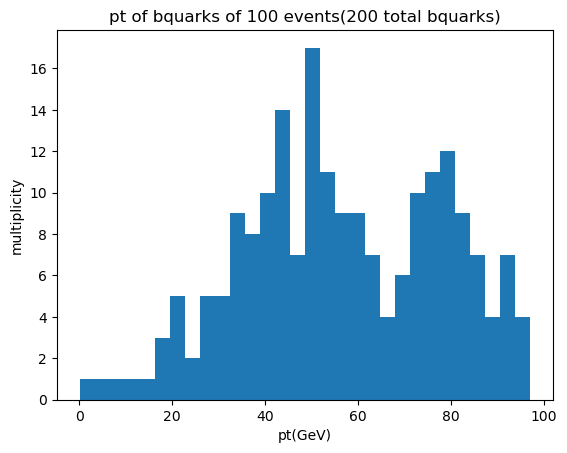

In [8]:
import matplotlib.pyplot as plt
bins = np.linspace(0,100,30)
plt.hist(bquark_arr[:,1], bins=30)
plt.title("pt of bquarks of 100 events(200 total bquarks)")
plt.xlabel("pt(GeV)")
plt.ylabel("multiplicity")

# match bquarks to jets by $\Delta$R

In [9]:
import awkward as ak
import fastjet
import numpy as np
import vector
import random

jetdef = fastjet.JetDefinition(fastjet.ee_genkt_algorithm, 0.7, -1.0)
min_jet_pt = 5.0  # GeV

# from fcc/postprocessing.py
X_FEATURES_TRK = [
    "elemtype",
    "pt",
    "eta",
    "sin_phi",
    "cos_phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]
X_FEATURES_CL = [
    "elemtype",
    "et",
    "eta",
    "sin_phi",
    "cos_phi",
    "energy",
    "position.x",
    "position.y",
    "position.z",
    "iTheta",
    "energy_ecal",
    "energy_hcal",
    "energy_other",
    "num_hits",
    "sigma_x",
    "sigma_y",
    "sigma_z",
]

Y_FEATURES = ["PDG", "charge", "pt", "eta", "sin_phi", "cos_phi", "energy", "jet_idx"]
labels = [0, 211, 130, 22, 11, 13]

N_X_FEATURES = max(len(X_FEATURES_CL), len(X_FEATURES_TRK))
N_Y_FEATURES = len(Y_FEATURES)


def split_sample(path, test_frac=0.8):
    files = sorted(list(path.glob("*.parquet")))
    print("Found {} files in {}".format(len(files), path))
    assert len(files) > 0
    idx_split = int(test_frac * len(files))
    files_train = files[:idx_split]
    files_test = files[idx_split:]
    assert len(files_train) > 0
    assert len(files_test) > 0
    return {
        "train": generate_examples(files_train),
        "test": generate_examples(files_test),
    }


def split_sample_several(paths, test_frac=0.8):
    files = sum([list(path.glob("*.parquet")) for path in paths], [])
    random.shuffle(files)
    print("Found {} files".format(len(files)))
    assert len(files) > 0
    idx_split = int(test_frac * len(files))
    files_train = files[:idx_split]
    files_test = files[idx_split:]
    assert len(files_train) > 0
    assert len(files_test) > 0
    return {
        "train": generate_examples(files_train),
        "test": generate_examples(files_test),
    }


def prepare_data_clic(fn, with_jet_idx=True):
    ret = ak.from_parquet(fn)
    X_track = ret["X_track"]
    X_cluster = ret["X_cluster"]
    bquark_features = ret["ygen_bquarks"]
    
    assert len(X_track) == len(X_cluster)
    nev = len(X_track)

    Xs = []
    ygens = []
    ycands = []
    matched_bquark_to_jet_all = {0:list(), 1:list()}
    distance_min_bquark_to_jet_all = {0:list(), 1:list()}
    distance_min_all = {0:list(), 1:list()}
    p4_matched_bquark_jet = list()
    overlaps = 0
    
    for iev in range(nev):

        X1 = ak.to_numpy(X_track[iev])
        X2 = ak.to_numpy(X_cluster[iev])
        bquark_feature = ak.to_numpy(bquark_features[iev])
        
        if len(X1) == 0 and len(X2) == 0:
            continue

        if len(X1) == 0:
            X1 = np.zeros((0, N_X_FEATURES))
        if len(X2) == 0:
            X2 = np.zeros((0, N_X_FEATURES))

        ygen_track = ak.to_numpy(ret["ygen_track"][iev])
        ygen_cluster = ak.to_numpy(ret["ygen_cluster"][iev])
        ycand_track = ak.to_numpy(ret["ycand_track"][iev])
        ycand_cluster = ak.to_numpy(ret["ycand_cluster"][iev])

        if len(ygen_track) == 0 and len(ygen_cluster) == 0:
            continue

        if len(ygen_track) == 0:
            ygen_track = np.zeros((0, N_Y_FEATURES - 1))
        if len(ygen_cluster) == 0:
            ygen_cluster = np.zeros((0, N_Y_FEATURES - 1))
        if len(ycand_track) == 0:
            ycand_track = np.zeros((0, N_Y_FEATURES - 1))
        if len(ycand_cluster) == 0:
            ycand_cluster = np.zeros((0, N_Y_FEATURES - 1))

        # pad feature dim between tracks and clusters to the same size
        if X1.shape[1] < N_X_FEATURES:
            X1 = np.pad(X1, [[0, 0], [0, N_X_FEATURES - X1.shape[1]]])
        if X2.shape[1] < N_X_FEATURES:
            X2 = np.pad(X2, [[0, 0], [0, N_X_FEATURES - X2.shape[1]]])

        # concatenate tracks and clusters in features and targets
        X = np.concatenate([X1, X2])
        ygen = np.concatenate([ygen_track, ygen_cluster])
        ycand = np.concatenate([ycand_track, ycand_cluster])

        if (ygen.shape[0] != X.shape[0]) or (ycand.shape[0] != X.shape[0]):
            print(X.shape, ygen.shape, ycand.shape)
            continue

        # add jet_idx column
        if with_jet_idx:
            ygen = np.concatenate(
                [
                    ygen.astype(np.float32),
                    np.zeros((len(ygen), 1), dtype=np.float32),
                ],
                axis=-1,
            )
            ycand = np.concatenate(
                [
                    ycand.astype(np.float32),
                    np.zeros((len(ycand), 1), dtype=np.float32),
                ],
                axis=-1,
            )

        # replace PID with index in labels array
        arr = np.array([labels.index(p) for p in ygen[:, 0]])
        ygen[:, 0][:] = arr[:]
        arr = np.array([labels.index(p) for p in ycand[:, 0]])
        ycand[:, 0][:] = arr[:]

        if with_jet_idx:
            # prepare gen candidates for clustering
            cls_id = ygen[..., 0]
            valid = cls_id != 0
            # save mapping of index after masking -> index before masking as numpy array
            # inspired from:
            # https://stackoverflow.com/questions/432112/1044443#comment54747416_1044443
            cumsum = np.cumsum(valid) - 1
            _, index_mapping = np.unique(cumsum, return_index=True)

            pt = ygen[valid, Y_FEATURES.index("pt")]
            eta = ygen[valid, Y_FEATURES.index("eta")]
            sin_phi = ygen[valid, Y_FEATURES.index("sin_phi")]
            cos_phi = ygen[valid, Y_FEATURES.index("cos_phi")]
            phi = np.arctan2(sin_phi, cos_phi)
            energy = ygen[valid, Y_FEATURES.index("energy")]
            vec = vector.awk(ak.zip({"pt": pt, "eta": eta, "phi": phi, "energy": energy}))
            
            # cluster jets, sort jet indices in descending order by pt
            cluster = fastjet.ClusterSequence(vec.to_xyzt(), jetdef)
            jets = vector.awk(cluster.inclusive_jets(min_pt=min_jet_pt))

            # match jet with the bquark that has the smallest deltaR
            bquark_pt = bquark_feature[:,1]
            bquark_eta = bquark_feature[:,2]
            bquark_phi = bquark_feature[:,3]
            bquark_E = bquark_feature[:,0]

            jets_xyzt = jets
            bquark_vec_xyzt = vector.awk(ak.zip({"pt": bquark_pt, "eta": bquark_eta, "phi": bquark_phi, "energy": bquark_E})).to_xyzt()
            
            num_jets = len(jets)
            num_bquarks = 2
            distance_bquark_to_jet = {0:list(), 1:list()}
            for i in range(num_bquarks):
                for j in range(num_jets):
                    distance_bquark_to_jet[i].append(bquark_vec_xyzt[i].deltaR(jets_xyzt[j]))

            matched_bquark_to_jet = {0:list(), 1:list()}
            distance_min_bquark_to_jet = {0:0, 1:0}  # record the distance between bquark and the closest to second closest jet
            distance_min = {0:0, 1:0}    # record the distance between bquark and the closest jet
            for i in range(2):
                matched_bquark_to_jet[i] = np.argmin(np.array(distance_bquark_to_jet[i]))
                
                temp_sorted_dis = sorted(distance_bquark_to_jet[i])
                
                distance_min_bquark_to_jet_all[i].append(temp_sorted_dis[1] - temp_sorted_dis[0])
                
                distance_min_bquark_to_jet[i] = (temp_sorted_dis[1] - temp_sorted_dis[0])
                
                distance_min_all[i].append(temp_sorted_dis[0])
                
                p4_matched_bquark_jet.append([bquark_vec_xyzt[i], jets_xyzt[matched_bquark_to_jet[i]]])
                
            # print(distance_min_bquark_to_jet)
            if matched_bquark_to_jet[0] == matched_bquark_to_jet[1]:
                overlaps += 1
            
            
            sorted_jet_idx = ak.argsort(jets.pt, axis=-1, ascending=False).to_list()
            # retrieve corresponding indices of constituents
            constituent_idx = cluster.constituent_index(min_pt=min_jet_pt).to_list()

            # add index information to ygen and ycand
            # index jets in descending order by pt starting from 1:
            # 0 is null (unclustered),
            # 1 is 1st highest-pt jet,
            # 2 is 2nd highest-pt jet, ...
            for jet_idx in sorted_jet_idx:
                jet_constituents = [
                    index_mapping[idx] for idx in constituent_idx[jet_idx]
                ]  # map back to constituent index *before* masking
                ygen[jet_constituents, Y_FEATURES.index("jet_idx")] = jet_idx + 1  # jet index starts from 1
                ycand[jet_constituents, Y_FEATURES.index("jet_idx")] = jet_idx + 1
        Xs.append(X)
        ygens.append(ygen)
        ycands.append(ycand)
        
    print("Number of jets that match to the same bquark: ", overlaps)
    return Xs, ygens, ycands, distance_min_bquark_to_jet_all, distance_min_all, p4_matched_bquark_jet


def generate_examples(files, with_jet_idx=True):
    for fi in files:
        print(fi)
        Xs, ygens, ycands, distance_min_bquark_to_jet_all, distance_min_all, p4_matched_bquark_jet = prepare_data_clic(fi, with_jet_idx=with_jet_idx)
        for iev in range(len(Xs)):
            yield str(fi) + "_" + str(iev), {
                "X": Xs[iev].astype(np.float32),
                "ygen": ygens[iev],
                "ycand": ycands[iev],
                "distance_min_bquark_to_jet_all":distance_min_bquark_to_jet_all,
                "distance_min_all":distance_min_all,
                "p4_matched_bquark_jet":p4_matched_bquark_jet,
            }

In [10]:
gen_features = generate_examples([ofn])
_, event = next(gen_features)

./btagging_tests/event1.parquet
#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Number of jets that match to the same b

Text(0.5, 1.0, '100 events, 200 total bquarks matching')

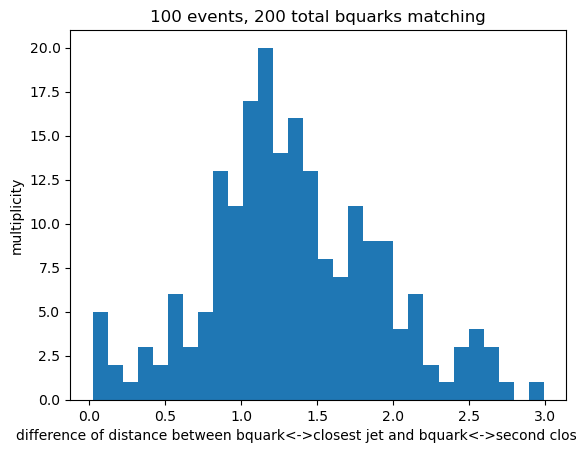

In [11]:
plt.hist(np.array(event["distance_min_bquark_to_jet_all"][0] + event["distance_min_bquark_to_jet_all"][1]), bins=30)
plt.xlabel("difference of distance between bquark<->closest jet and bquark<->second closest jet")
plt.ylabel("multiplicity")
plt.title("100 events, 200 total bquarks matching")

176


Text(0.5, 1.0, '100 events, 200 total bquarks matching')

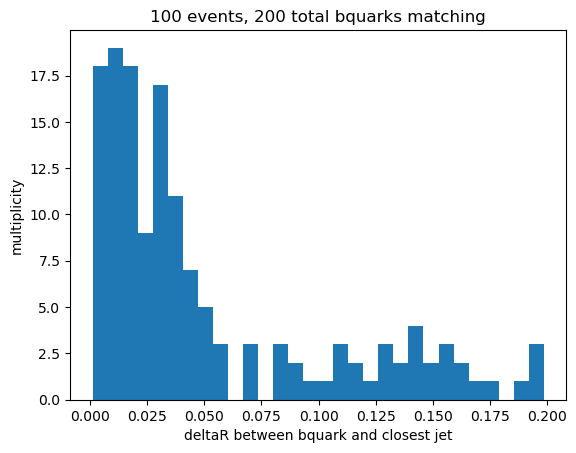

In [13]:
plot_arr = np.array(event["distance_min_all"][0] + event["distance_min_all"][1])
print(len(plot_arr[plot_arr < 0.5]))
plt.hist(plot_arr[plot_arr < 0.2], bins=30)
plt.xlabel("deltaR between bquark and closest jet")
plt.ylabel("multiplicity")
plt.title("100 events, 200 total bquarks matching")

In [20]:
bquark_dict = {"E":list(), "pT":list(), "eta":list(), "phi":list()}
jet_dict = {"E":list(), "pT":list(), "eta":list(), "phi":list()}

for bquark, jet in event["p4_matched_bquark_jet"]:
    bquark_dict["E"].append(bquark.energy)
    bquark_dict["pT"].append(bquark.pt)
    bquark_dict["eta"].append(bquark.eta)
    bquark_dict["phi"].append(bquark.phi)
    
    jet_dict["E"].append(jet.energy)
    jet_dict["pT"].append(jet.pt)
    jet_dict["eta"].append(jet.eta)
    jet_dict["phi"].append(jet.phi)

In [21]:
jet_dict["pT"]

[85.31745774997914,
 49.84450796863783,
 43.911053450636686,
 82.98769324630506,
 57.475668756987396,
 51.20070790234652,
 78.03672581114604,
 112.73636671951742,
 90.81575541746989,
 66.85992608037125,
 39.80167763192003,
 49.110400436649655,
 74.15948988377876,
 94.63156950245981,
 120.97594461195379,
 43.86822431912133,
 55.84940514083255,
 73.81174368487767,
 55.49331439533435,
 63.00355944566035,
 59.647964939757074,
 100.6256650023475,
 29.569097727363552,
 29.569097727363552,
 34.04891592497108,
 89.59044061141826,
 58.795369771126865,
 69.3248705107996,
 17.889097621522897,
 63.438058317455194,
 76.00547387963938,
 84.19550901394332,
 79.4805791635258,
 24.431700227053746,
 48.56978475274994,
 48.56978475274994,
 64.71546680214217,
 6.69400982099945,
 75.302550494188,
 41.00725950824809,
 62.56461514627327,
 94.01797013663838,
 13.98063564406952,
 27.504177675548984,
 27.964244404882535,
 23.131200254643602,
 45.971557805905846,
 45.971557805905846,
 107.4302086453221,
 107.430

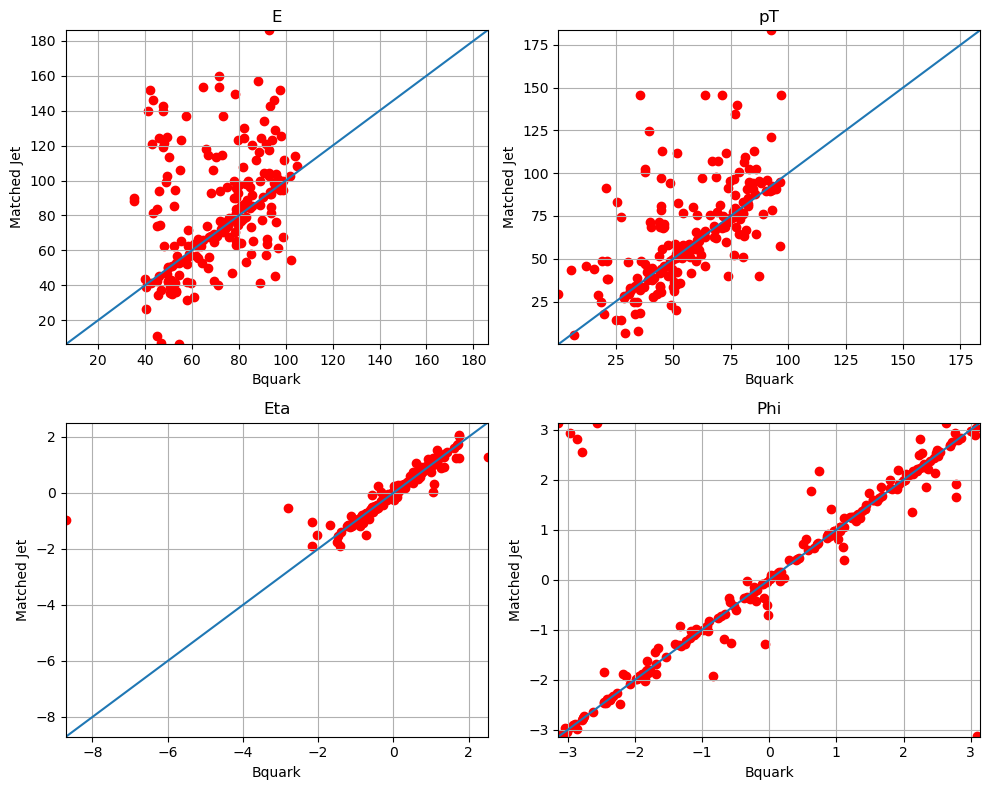

In [27]:
# plot correlation of p4

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First scatter plot
Min, Max = min(min(bquark_dict["E"]), min(jet_dict["E"])), max(max(bquark_dict["E"]), max(jet_dict["E"]))
x = np.linspace(Min,Max,100)
axs[0, 0].plot(x,x)
axs[0, 0].scatter(bquark_dict["E"], jet_dict["E"], color='r')
axs[0, 0].set_title('E')
axs[0, 0].set_ylim([Min,Max])
axs[0, 0].set_xlim([Min,Max])
axs[0, 0].set_ylabel("Matched Jet")
axs[0, 0].set_xlabel("Bquark")
axs[0, 0].grid(True)

# Second scatter plot
Min, Max = min(min(bquark_dict["pT"]), min(jet_dict["pT"])), max(max(bquark_dict["pT"]), max(jet_dict["pT"]))
x = np.linspace(Min,Max,100)
axs[0, 1].plot(x,x)
axs[0, 1].scatter(bquark_dict["pT"], jet_dict["pT"], color='r')
axs[0, 1].set_title('pT')
axs[0, 1].set_ylim([Min,Max])
axs[0, 1].set_xlim([Min,Max])
axs[0, 1].set_ylabel("Matched Jet")
axs[0, 1].set_xlabel("Bquark")
axs[0, 1].grid(True)

# Third scatter plot
Min, Max = min(min(bquark_dict["eta"]), min(jet_dict["eta"])), max(max(bquark_dict["eta"]), max(jet_dict["eta"]))
x = np.linspace(Min,Max,100)
axs[1, 0].plot(x,x)
axs[1, 0].scatter(bquark_dict["eta"], jet_dict["eta"], color='r')
axs[1, 0].set_title('Eta')
axs[1, 0].set_ylim([Min,Max])
axs[1, 0].set_xlim([Min,Max])
axs[1, 0].set_ylabel("Matched Jet")
axs[1, 0].set_xlabel("Bquark")
axs[1, 0].grid(True)

# Fourth scatter plot
Min, Max = min(min(bquark_dict["phi"]), min(jet_dict["phi"])), max(max(bquark_dict["phi"]), max(jet_dict["phi"]))
x = np.linspace(Min,Max,100)
axs[1, 1].plot(x,x)
axs[1, 1].scatter(bquark_dict["phi"], jet_dict["phi"], color='r')
axs[1, 1].set_title('Phi')
axs[1, 1].set_ylim([Min,Max])
axs[1, 1].set_xlim([Min,Max])
axs[1, 1].set_ylabel("Matched Jet")
axs[1, 1].set_xlabel("Bquark")
axs[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [54]:
ret = ak.from_parquet(ofn)
X_track = ret["X_track"]
X_cluster = ret["X_cluster"]
bquark_features = ret["ygen_bquarks"]

with_jet_idx = True

assert len(X_track) == len(X_cluster)
nev = len(X_track)

Xs = []
ygens = []
ycands = []
iev = 0

X1 = ak.to_numpy(X_track[iev])
X2 = ak.to_numpy(X_cluster[iev])
bquark_feature = ak.to_numpy(bquark_features[iev])

if len(X1) == 0:
    X1 = np.zeros((0, N_X_FEATURES))
if len(X2) == 0:
    X2 = np.zeros((0, N_X_FEATURES))

ygen_track = ak.to_numpy(ret["ygen_track"][iev])
ygen_cluster = ak.to_numpy(ret["ygen_cluster"][iev])
ycand_track = ak.to_numpy(ret["ycand_track"][iev])
ycand_cluster = ak.to_numpy(ret["ycand_cluster"][iev])

if len(ygen_track) == 0:
    ygen_track = np.zeros((0, N_Y_FEATURES - 1))
if len(ygen_cluster) == 0:
    ygen_cluster = np.zeros((0, N_Y_FEATURES - 1))
if len(ycand_track) == 0:
    ycand_track = np.zeros((0, N_Y_FEATURES - 1))
if len(ycand_cluster) == 0:
    ycand_cluster = np.zeros((0, N_Y_FEATURES - 1))

# pad feature dim between tracks and clusters to the same size
if X1.shape[1] < N_X_FEATURES:
    X1 = np.pad(X1, [[0, 0], [0, N_X_FEATURES - X1.shape[1]]])
if X2.shape[1] < N_X_FEATURES:
    X2 = np.pad(X2, [[0, 0], [0, N_X_FEATURES - X2.shape[1]]])

# concatenate tracks and clusters in features and targets
X = np.concatenate([X1, X2])
ygen = np.concatenate([ygen_track, ygen_cluster])
ycand = np.concatenate([ycand_track, ycand_cluster])

if (ygen.shape[0] != X.shape[0]) or (ycand.shape[0] != X.shape[0]):
    print(X.shape, ygen.shape, ycand.shape)

# add jet_idx column
if with_jet_idx:
    ygen = np.concatenate(
        [
            ygen.astype(np.float32),
            np.zeros((len(ygen), 1), dtype=np.float32),
        ],
        axis=-1,
    )
    ycand = np.concatenate(
        [
            ycand.astype(np.float32),
            np.zeros((len(ycand), 1), dtype=np.float32),
        ],
        axis=-1,
    )

# replace PID with index in labels array
arr = np.array([labels.index(p) for p in ygen[:, 0]])
ygen[:, 0][:] = arr[:]
arr = np.array([labels.index(p) for p in ycand[:, 0]])
ycand[:, 0][:] = arr[:]


# prepare gen candidates for clustering
cls_id = ygen[..., 0]
valid = cls_id != 0
# save mapping of index after masking -> index before masking as numpy array
# inspired from:
# https://stackoverflow.com/questions/432112/1044443#comment54747416_1044443
cumsum = np.cumsum(valid) - 1
_, index_mapping = np.unique(cumsum, return_index=True)

pt = ygen[valid, Y_FEATURES.index("pt")]
eta = ygen[valid, Y_FEATURES.index("eta")]
sin_phi = ygen[valid, Y_FEATURES.index("sin_phi")]
cos_phi = ygen[valid, Y_FEATURES.index("cos_phi")]
phi = np.arctan2(sin_phi, cos_phi)
energy = ygen[valid, Y_FEATURES.index("energy")]
vec = vector.awk(ak.zip({"pt": pt, "eta": eta, "phi": phi, "energy": energy}))

# cluster jets, sort jet indices in descending order by pt
cluster = fastjet.ClusterSequence(vec.to_xyzt(), jetdef)
jets = vector.awk(cluster.inclusive_jets(min_pt=min_jet_pt))

In [57]:
bquark_pt = bquark_feature[:,1]
bquark_eta = bquark_feature[:,2]
bquark_phi = bquark_feature[:,3]
bquark_E = bquark_feature[:,0]

jets_xyzt = jets
bquark_vec_xyzt = vector.awk(ak.zip({"pt": bquark_pt, "eta": bquark_eta, "phi": bquark_phi, "energy": bquark_E})).to_xyzt()

In [59]:
# calculate distance
bquark_vec_xyzt

<MomentumArray4D [{x: -33.6, y: -75.5, z: ..., ...}, ...] type='2 * Momentu...'>

In [65]:
distance_bquark_to_jet = {0:list(), 1:list()}
for i in range(2):
    for j in range(6):
        distance_bquark_to_jet[i].append(bquark_vec_xyzt[i].deltaR(jets_xyzt[j]))

In [66]:
distance_bquark_to_jet

{0: [1.807797695497047,
  2.7847055640031977,
  2.22216764853701,
  1.6904859807429575,
  2.727804649914385,
  0.03270411683427316],
 1: [2.977511794874349,
  3.4227621043616008,
  2.0618636558606256,
  0.007408639640439507,
  2.2290909588088597,
  1.7140271367202757]}